In [2]:
# This notebook is for debugging general functions (from utils.py) for example.

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ArtistAnimation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

from IPython.display import clear_output

from lib.CAModel import CAModel
from lib.PonderCAModel import PonderCAModel
from lib.AdaptiveFireRateCAModel import AdaptiveFireRateCAModel
from lib.EnergyCAModel import EnergyCAModel

from lib.utils_vis import SamplePool, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks, damage_batch
from lib.utils import *
from lib.losses import ReconstructionLoss, RegularizationLoss, ReconstructionLoss_AdaptFireRate, RegularizationLoss_AdaptFireRate

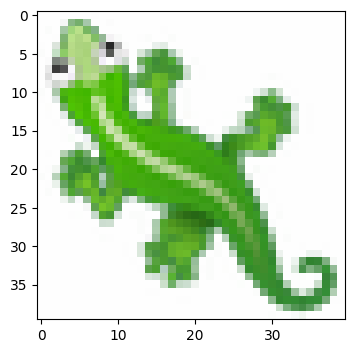

In [3]:
# params
device = torch.device("cpu")

CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

lr = 2e-3
lr_gamma = 0.9999 ###currently not used
betas = (0.5, 0.5)
n_epoch = 8000

BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = 0 #@param "🦎"
EMOJI_NAME = "Lizard"
EXPERIMENT_TYPE = "Growing"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch


## PonderNet and AdaptiveFireRateCA Params ##
IMG_SIZE = 72       # final padded image side length
LAMBDA_P = 1/3      # reasonable 1/expected_steps (interpretation for PonderCA)
                     
MAX_STEPS = 100
BETA = 0.01         # regularization param

## EnergyCA Params ##
BETA_ENERGY = 1e-6
MIN_FIRERATE = 0.01
MAX_FIRERATE = 0.8


target_img = load_emoji(TARGET_EMOJI)
plt.figure(figsize=(4,4))
plt.imshow(to_rgb(target_img))
plt.show()


In [4]:
# Create pad_target
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32))
debug("pad_target.shape")


pad_target.shape = torch.Size([1, 72, 72, 4])


In [5]:
# Create a batch by expanding dim=0 to BATCH_SIZE
batch = pad_target.repeat(BATCH_SIZE, 1, 1, 1)

# expand the channels in the last dimension to CHANNEL_N
batch = batch.repeat(1, 1, 1, 4)

debug("batch.shape")

batch.shape = torch.Size([8, 72, 72, 16])


## Debugging utils_vis.py

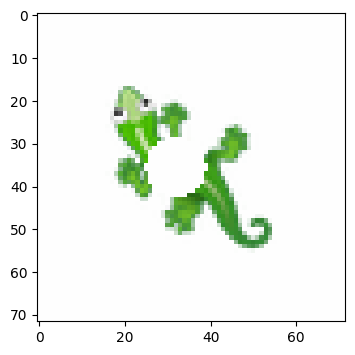

In [150]:
# Test functionality of damage_batch
batch_damaged = damage_batch(batch, device, img_size = IMG_SIZE, damage_location="center" , damaged_in_batch = 1)
plt.figure(figsize=(4,4))
plt.imshow(to_rgb(batch_damaged[0]))
plt.show()


## Debugging training stuff

target_mask.shape = torch.Size([100, 8, 72, 72])


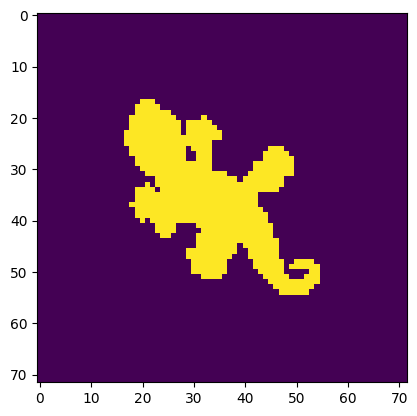

In [18]:
# what the fireRate of a cell should be, throughout time
#decay_map = torch.from_numpy(np.exp(np.linspace(np.log(0.5),np.log(0.1), 100)))
# mask in the shape of pad_target, with 1's where the target is
target_mask = (pad_target[:,:,:,3] > 0.1).unsqueeze(0).repeat(100,BATCH_SIZE, 1, 1)
debug("target_mask.shape")
decay_map = torch.from_numpy(np.linspace(MAX_FIRERATE, MIN_FIRERATE, 100))
min_fireRatestest = torch.einsum("i,ijkl -> ijkl", decay_map, torch.ones(100, BATCH_SIZE, IMG_SIZE, IMG_SIZE))
#plt.plot(min_fireRatestest.numpy()[:,0,36,36])
plt.imshow(target_mask[0,0,:,:].numpy())
#animate_steps(min_fireRatestest.detach().cpu(), colorbar_plots=[0])

pad_target.shape = torch.Size([1, 72, 72, 4])


/tmp/ipykernel_3737694/492315354.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(pad_target[0,:,:,1]))


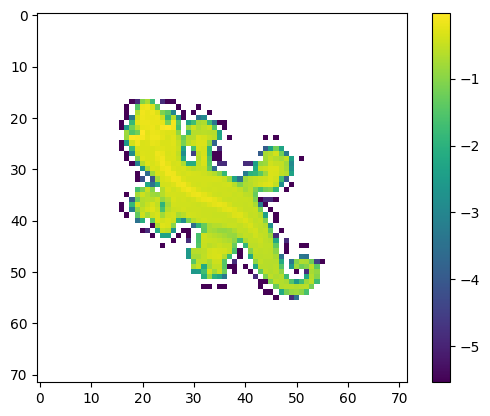

In [24]:
debug("pad_target.shape")
plt.imshow(np.log(pad_target[0,:,:,1]))
plt.colorbar()

In [5]:
torch.ones(100,8,72,72,1).squeeze(-1).shape

torch.Size([100, 8, 72, 72])

## Debugging utils.py

target_img.shape = (40, 40, 4)
target_img.shape = (40, 40, 4)


/tmp/ipykernel_3737694/3176162490.py:16: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(target_img[:,:,0]))


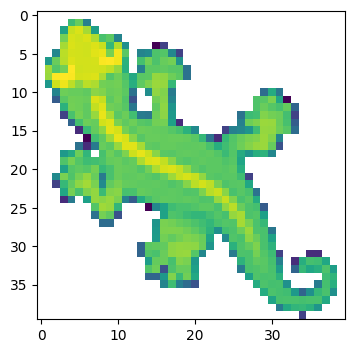

In [42]:
target_img = load_emoji(0)
debug("target_img.shape")

# create new image with only the elements of target_img in places where the sum of the channels is > 0.1
# this is to remove the random non-zero pixels

# mask where the sum of the channels is > 0.1
mask = (target_img.sum(axis=2) > 0.1)

# create new image with only the elements of target_img in places where the sum of the channels is > 0.1
target_img = target_img * mask[:,:,np.newaxis]

debug("target_img.shape")
# display the new image
plt.figure(figsize=(4,4))
plt.imshow(np.log(target_img[:,:,0]))
plt.show()

# save only the rgb channels of the image as png
plt.imsave("lizard_clean.png", target_img[:,:,:3])

lizard_clean.shape = (40, 40, 4)
lizard_dirty.shape = (40, 40, 4)


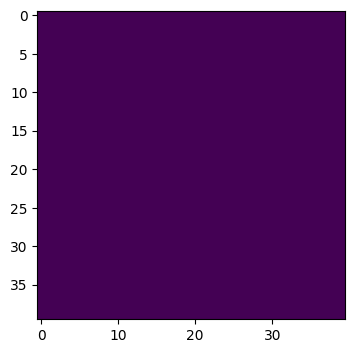

In [47]:
lizard_clean = load_lizard()
lizard_dirty = load_emoji(0)
debug("lizard_clean.shape")
debug("lizard_dirty.shape")
plt.figure(figsize=(4,4))
plt.imshow(lizard_clean[:,:,3]>0)
plt.show()

# Debugging EnergyCA

probs.shape = torch.Size([2, 2, 4, 2])


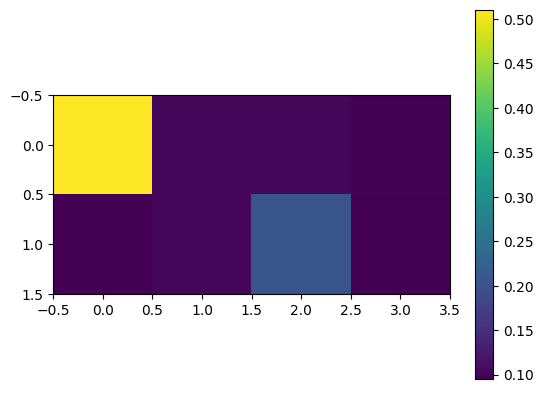

In [101]:
# trying gumbel softmax
probs = np.array([
    [[0.8,0.2, 0.1, 0.5], [0.1,0.1,0.1,0.1]],
    [[0.5,0.1,0.1,0.1], [0.1,0.1,0.2,0.1]],
    ])
probs = torch.from_numpy(probs).unsqueeze(-1)
probs = torch.cat([probs, 1-probs], dim=-1) # gumbel softmax requires #channels = #classes, we have 2 classes: fire or no fire
debug("probs.shape")
logits = torch.log(probs)

# do histogram over multiple samples

updates_gumbel = []
for i in range(10000):
    updates_gumbel.append(torch.nn.functional.gumbel_softmax(logits, hard=True))

updates_gumbel = torch.stack(updates_gumbel)
updates_gumbel = updates_gumbel.sum(axis=0) / 10000
plt.imshow(updates_gumbel[1,:,:,0].numpy())
plt.colorbar()


